<a href="https://colab.research.google.com/github/szchen01/Synthetic-Promoter-Data-CNN/blob/main/synthetic_promoter_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.functional import Tensor
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
import math

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Random seed set as {seed}")

set_seed(42)

Random seed set as 42


# 1. Generate Seq Strings

In [ ]:
bases = ['A', 'T', 'C', 'G']

# generate n random sequences
def randseq(length, quantity, motif, seven_scale=False):
  seqs, mots = [], []
  for _ in range(quantity):
    seq = ''
    for _ in range(length):
      seq += np.random.choice(bases)
    seqs.append(seq)

# seven_scale only works for length 7 sequences
    if seven_scale:
      accuracy = 0
      for i in range(7):
        if seq[i] == motif[i]:
          accuracy += 1
      mots.append(accuracy)

    else:
      if motif in seq:
        mots.append(1)
      else:
        mots.append(0)

  return seqs, mots

# generate n sequences with GATTACA
def motifseq(length, quantity, motif, seven_scale=False):
  seqs, mots = [], []
  for _ in range(quantity):
    seq = ''
    pos = np.random.randint(0, length - len(motif) + 1)
    for i in range(length + 1 - len(motif)):
      if i == pos:
        seq += motif
      else:
        seq += np.random.choice(bases)
    seqs.append(seq)
    if seven_scale:
      mots.append(7)
    else:
      mots.append(1)

  return seqs, mots

def generate_seq(length, quantity, motif, seven_scale=False):
  r = randseq(length, quantity // 2, motif, seven_scale=seven_scale)
  m = motifseq(length, quantity // 2, motif, seven_scale=seven_scale)
  return r[0] + m[0], r[1] + m[1]

In [ ]:
# construct list of sequences and corresponding list of labels
gat = 'GATTACA'
simpseqs = generate_seq(20, 50, gat)
seqs, gats = generate_seq(250, 1000, gat)
zips = list(zip(seqs, gats))
random.shuffle(zips)
print(zips[:8])
shortseqs,shortgats = generate_seq(7,1000,gat)
shortzips = list(zip(shortseqs, shortgats))
random.shuffle(shortzips)


[('GCTACATGTTATCCATAAAACAAAGGGTGCAAGCTTTAAAGACTGGTTCCTTTCTGTCCCCATTCTGATGCACCGAATCTTTCCGTAACCTGTGGACCTGTGGACTTAGGGGCAAAAGAGTAGCAACGTCTGTTCAACGCTAACAGCAGACCGTCGGGCTTTTATAAGATGTAACCTCGCTGTGACACGAGCATTGGAAGGCGTGCCTCGATGATATATGATTACAGAGGTCGCAGCCGTGCTTACCGCG', 1), ('AAGAATCATATTCTGAGGGATTACACGCAACTCCGAAACCACAGGCTAGTGAAGCATTCGAACAATTGTGTGAATAGCCAATTGGCGAATAGGTGTATGGCTGCAAAAATAGGAACTGGGGAATCAGCGTATGAAAATACAGTCGAGTTACTTCAGAAGGACGTATTGCTAGTAAATCTCCGGCTCCCACACTGGACTATCGCCCGGAAAGGCCTTACCTACTAAATCTCCCGGGACATCGTGTCCAGGC', 1), ('TCGGCCCGCAAACCAACCGAGGACGTCGTCTAGTAGAGTACGGATAGGCGTGACAGGAGTTAAACTATAGGCGGCAGCAAGGTTGGATTACATATATAAACCAGGGGATTGCGGAGGCACGATTAGACGCATAAGTTCCGTATTGAAGTACTGCACCCTTGAAGCTCGTTATGTAAAAGGTTTTCTTCCCCCTATTATTATATCATCGGTTTGACGCTGAGCCAGGCTGTACGCTGGCCCAAACGCCAGC', 1), ('CCGAAGTATAGTGGTTAGTCGGCCTATTAGTTCCATCCGCACGTTTCATAGCACAACGATGACAGTGGGAAACCCGCTGGATCTCACTCTCCTCCTTGCTTTGGGCTCAGCAAACAACTTCAGGTGCGAAGTTACCGATCCTTGTGGCGAGCGCAACAAGCTGTTCCAGATTACACATTGACGGCGTCGGTTGAGGAGGTTAGTCTGGTCTTCCTCATTT

In [ ]:
gat = 'GATTACA'
sevseqs, sevlabels = generate_seq(7, 1000, gat, seven_scale=True)
sevzips = list(zip(sevseqs, sevlabels))
random.shuffle(sevzips)

## Sanity check tests

In [ ]:
# sanity check
print(f'gats in simpseqs: {sum([gat in seq for seq in simpseqs])}')
print(f'gats in seqs: {sum([gat in seq for seq in seqs])}')
print(f'length of simpseqs: {len(simpseqs)}')
print(f'length of seqs: {len(seqs)}')
print(f'length of shortseqs: {len(shortseqs)}')
print(all([len(x) == 250 for x in seqs]))
print([len(x) for x in seqs])
print(f'gats in shortseqs: {sum([gat in seq for seq in shortseqs])}')
print(f'gats in shortseqs: {sum([gat in seq for seq in shortseqs])}')


gats in simpseqs: 0
gats in seqs: 503
length of simpseqs: 2
length of seqs: 1000
length of shortseqs: 1000
True
[250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 25

In [ ]:
#sanity check
print(sum(gat in tup[0] for tup in zips[:500]))
print(all(gat in tup[0] for tup in shortzips if tup[1] == 1))
print(all(gat not in tup[0] for tup in zips if tup[1] == 0))
print(all([len(tup[0]) == 250 for tup in zips]))
print([len(tup[0]) for tup in zips])

243
True
True
True
[250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 

# 2. Building Datasets and Dataloaders + Encoding Data

## Sequence Datasets + DLs

In [ ]:
# char to int conversion dictionaries
btoi = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
itob = {i:b for b,i in btoi.items()}
print(itob)

{0: 'A', 1: 'C', 2: 'G', 3: 'T'}


In [ ]:
class SeqDatasetOHE(Dataset):
    def __init__(self,
                 df,
                 seq_col='seq',
                 target_col='score'
                ):

        self.ohe_seqs = df[0]
        self.seq_len = len(self.ohe_seqs[0])
        self.labels = df[1].unsqueeze(1)

    def __len__(self): return len(self.ohe_seqs)

    def __getitem__(self,idx):
        # Given an index, return a tuple of an X with it's associated Y
        # This is called inside DataLoader
        seq = self.ohe_seqs[idx]
        label = self.labels[idx]

        return seq, label
def build_dataset(tuples):
  X, Y = [], []
  for tup in tuples:
    temp = []
    for b in tup[0]:
      ib = btoi[b]
      temp.append(ib)
    X.append(temp)
    Y.append(tup[1])

  X = Tensor(X)
  Y = Tensor(Y)
  X = X.view(X.shape[0], -1)
  Y = Y.view(Y.shape[0], 1, 1)
  print(X.shape, Y.shape)
  return X, Y

def enc(x):
  xenc = F.one_hot(x.to(torch.int64), num_classes = 4)
  xenc = xenc.permute((0,2,1))
  xenc = xenc.float()
  return xenc

In [ ]:
# extract data from zips
n1 = int(0.8*len(zips))
n2 = int(0.9*len(zips))
Xtr,  Ytr  = build_dataset(zips[:n1])     # 80%
Xdev, Ydev = build_dataset(zips[n1:n2])   # 10%
Xte,  Yte  = build_dataset(zips[n2:])     # 10%

# short test data
sXtr, sYtr = build_dataset(shortzips[:n1])
sXdev, sYdev = build_dataset(shortzips[n1:n2])   # 10%
sXte,  sYte  = build_dataset(shortzips[n2:])     # 10%

# seven scale data
sevXtr, sevYtr = build_dataset(sevzips[:n1])
sevXdev, sevYdev = build_dataset(sevzips[n1:n2])   # 10%
sevXte,  sevYte  = build_dataset(sevzips[n2:])     # 10%


# encode data one hot
Xtr = enc(Xtr)
Xdev = enc(Xdev)
Xte = enc(Xte)
sXtr = enc(sXtr)
sXdev = enc(sXdev)
sXte = enc(sXte)
sevXtr = enc(sevXtr)
sevXdev = enc(sevXdev)
sevXte = enc(sevXte)

#build tuples of data
train_df = (Xtr, Ytr)
val_df = (Xdev, Ydev)
sTrain_df = (sXtr, sYtr)
sVal_df = (sXdev, sYdev)
sevTrain_df = (sevXtr, sevYtr)
sevVal_df = (sevXdev, sevYdev)

train_ds = SeqDatasetOHE(train_df,seq_col='seq',target_col='score')
val_ds = SeqDatasetOHE(val_df,seq_col='seq',target_col='score')
sTrain_ds = SeqDatasetOHE(sTrain_df,seq_col='seq',target_col='score')
sVal_ds = SeqDatasetOHE(sVal_df,seq_col='seq',target_col='score')
sevTrain_ds = SeqDatasetOHE(sevTrain_df,seq_col='seq',target_col='score')
sevVal_ds = SeqDatasetOHE(sevVal_df,seq_col='seq',target_col='score')

torch.Size([800, 250]) torch.Size([800, 1, 1])
torch.Size([100, 250]) torch.Size([100, 1, 1])
torch.Size([100, 250]) torch.Size([100, 1, 1])
torch.Size([800, 7]) torch.Size([800, 1, 1])
torch.Size([100, 7]) torch.Size([100, 1, 1])
torch.Size([100, 7]) torch.Size([100, 1, 1])
torch.Size([800, 7]) torch.Size([800, 1, 1])
torch.Size([100, 7]) torch.Size([100, 1, 1])
torch.Size([100, 7]) torch.Size([100, 1, 1])


In [ ]:
#data loaders
def build_dataloaders(trainData,
                      valData,
                      batch_size = 200
                      ):
  train_dl = DataLoader(trainData, batch_size=batch_size)
  val_dl = DataLoader(valData, batch_size=batch_size)
  return train_dl, val_dl

In [ ]:
xTr_dl, xVal_dl = build_dataloaders(train_ds, val_ds)
sxTr_dl, sxVal_dl = build_dataloaders(sTrain_ds, sVal_ds)
sevxTr_dl, sevxVal_dl = build_dataloaders(sevTrain_ds, sevVal_ds)

## Line Data Test

In [ ]:
def random_list(length):
  return_list = []
  for _ in range(length):
    rand = np.random.randint(-1000, 1000)
    return_list.append(rand)
  return return_list
def line(input_list):
  return_list = []
  for x in input_list:
    y = 5 * x + 3
    return_list.append(y)
  return return_list


torch.Size([1000, 1, 1])
torch.Size([1000, 1, 1])


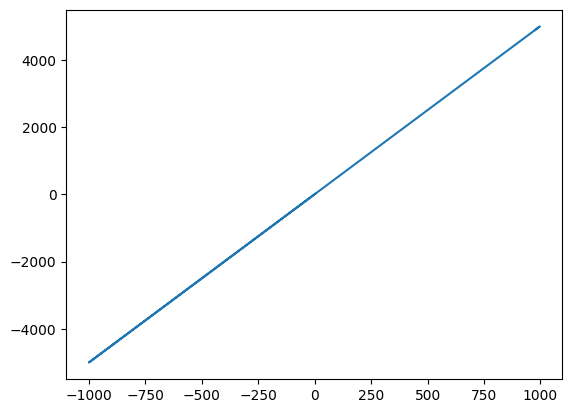

In [ ]:
list_len = 1000

line_x = random_list(list_len)
line_y = line(line_x)
line_x = Tensor(line_x)
line_y = Tensor(line_y)
plt.plot(line_x, line_y)
line_x = line_x.view(list_len, 1, 1)
line_y = line_y.reshape(list_len , 1, 1)
print(line_x.shape)
print(line_y.shape)

In [ ]:
class LinearDataset(Dataset):
  def __init__(self,
                 x,
                 y,
                 seq_col='seq',
                 target_col='score'
                ):

      self.seqs = x
      self.y = y
      self.seq_len = 1
      self.labels = y

  def __len__(self): return len(self.seqs)

  def __getitem__(self,idx):
      # Given an index, return a tuple of an X with it's associated Y
      # This is called inside DataLoader
      seq = self.seqs[idx]
      label = self.labels[idx]

      return seq, label

In [ ]:
line_batch_size = 50

line_df = (line_x, line_y)
line_ds = LinearDataset(line_x, line_y, seq_col = 'seq', target_col='score')
line_dl = DataLoader(line_ds, batch_size = line_batch_size)

# 3. Define Training Functions

In [ ]:
import torch.optim as optim

def loss_batch(model=None, xb=None, yb=None, loss_func=None, opt=None, verbose=False, device=None, reg=None, lamb=None):
  # if no optimizer provided, skip backprop
  # if verbose:
  decoded_xb = torch.argmax(xb, dim=1)
  strings = []
  for seq in decoded_xb:
    seq_str = ''
    for base in seq:
      base = base.item()
      seq_str += itob[base]
    strings.append(seq_str)
  ys = []
  for item in yb:
    item = item.item()
    ys.append(item)

  testzips = zip(strings, ys)

  assert all([tup[1] != 0 for tup in testzips if tup[0] == gat]), 'data is wrongly labelled'
  assert all([tup[0] != gat for tup in testzips if tup[1] != 1])
  assert all([tup[0] == gat for tup in testzips if tup[1] == 1])

  # print(f'xb shape: {xb.shape}')
  xb_out = model(xb)
  # print(f'xb_out shape: {xb_out.shape}')
  # print(f'yb shape: {yb.shape}')
  yb = torch.flatten(yb, 1)
  # print(f'yb shape flat: {yb.shape}')

  if reg:
    if not lamb:
      lamb = 0.001
    # l1_reg = Tensor(0)
    # for param in model.parameters():
    #   l1_reg += lamb * abs(param)

    loss = loss_func(xb_out, yb) + reg(model.parameters(), lamb)
    # loss = loss_func(xb_out, yb) + reg(layers[0].parameters(), lamb)
  else:
    loss = loss_func(xb_out, yb)


  if opt:
    loss.backward()
    opt.step()
    opt.zero_grad()

  return loss.item(), len(xb)

def train_step(model=None, train_dl=None, loss_func=None, opt=None, device=None, reg=None, lamb=None):
  model.train()
  tl = [] # training losses
  ns = [] # batch sizes

  for xb, yb in train_dl:
    xb, yb = xb.to(device), yb.to(device)
    t, n = loss_batch(model, xb, yb, loss_func, opt = opt, device=device, reg=reg, lamb=lamb)
    tl.append(t)
    ns.append(n)

  train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)


  return train_loss

def val_step(model=None, val_dl=None, loss_func=None, device=None):
  model.eval()
  with torch.no_grad():
    vl = []
    ns = []

    for xb, yb in val_dl:
      xb, yb = xb.to(device), yb.to(device)
      v, n = loss_batch(model, xb, yb, loss_func, device=device)
      vl.append(v)
      ns.append(n)

  val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)

  return val_loss

def fit(epochs=None, model=None, loss_func=None, opt=None, train_dl=None, val_dl=None, device=None, reg=None, lamb=None):
  train_losses = []
  val_losses = []
  print(opt)
  for epoch in range(epochs):
    train_loss = train_step(model, train_dl, loss_func, opt, device=device, reg=reg, lamb=lamb)
    train_losses.append(train_loss)
    val_loss = val_step(model=model, val_dl=val_dl, loss_func=loss_func, device=device)
    val_losses.append(val_loss)

    print(f"E{epoch} | train loss: {train_loss:.3f} | val loss: {val_loss:.3f}")

  return train_losses, val_losses

def run(train_dl=None, val_dl=None, model=None, lr=0.01, epochs = 100, loss_func=None, opt=None, device=None, reg=None, lamb=None):
  if not opt:
    opt = optim.Adam(model.parameters(), lr=lr)
  if not loss_func:
    loss_func = nn.MSELoss()

  train_losses, val_losses = fit(epochs,
                     model,
                     loss_func,
                     opt,
                     train_dl,
                     val_dl,
                     device=device,
                     reg=reg,
                     lamb=lamb
                     )
  return train_losses, val_losses


In [ ]:
def l1_reg(params, l1_lambda):
  l1_norm = sum(p.abs().sum() for p in params)
  return l1_lambda*l1_norm

def get_myLayer_from_model(model):
    '''
    extract custom layer weights
    '''
    model_children = list(model.children())

    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    layers = [] # we will save the actual conv layers in this list

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        # get model type of Conv1d
        if isinstance(model_children[i], myLayer):
            model_weights.append(model_children[i].weight)
            layers.append(model_children[i])

        # also check sequential objects' children for conv1d
        elif isinstance(model_children[i], nn.Sequential):
            for child in model_children[i]:
                if isinstance(child, myLayer):
                    model_weights.append(child.weight)
                    layers.append(child)
    return layers, model_weights

# 4. Defining and Running Linear Model

## Linear Model

In [ ]:
class LinearNet(nn.Module):
    def __init__(self, seq_length):
      super().__init__()
      self.seq_length = seq_length
      self.flatten = nn.Flatten(1)
      self.lin1 = nn.Linear(seq_length * 4, 100, bias=True)
      # self.lin2 = nn.Linear(100, 1)
      self.sig = nn.Sigmoid()
    def forward(self, x):

      x = self.flatten(x)
      # x = x.view(x.shape[0], -1, 1)
      # print(x.shape)
      # print(x)
      x = self.lin1(x)
      # x = self.sig(x)
      # x = self.lin2(x)

      # x = self.tanh(x)
      # print(x.shape)
      return x



## Run

In [ ]:
model_lin = LinearNet(seq_length=7)
lin_losses = run(sxTr_dl,
                 sxVal_dl,
                 model_lin,
                 lr = 0.001,
                 epochs = 100
                 )

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
E0 | train loss: 0.617 | val loss: 0.544


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([200, 1])) that is different to the input size (torch.Size([200, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


E1 | train loss: 0.582 | val loss: 0.513
E2 | train loss: 0.548 | val loss: 0.484
E3 | train loss: 0.516 | val loss: 0.456
E4 | train loss: 0.486 | val loss: 0.430
E5 | train loss: 0.457 | val loss: 0.405
E6 | train loss: 0.430 | val loss: 0.381
E7 | train loss: 0.404 | val loss: 0.359
E8 | train loss: 0.380 | val loss: 0.338
E9 | train loss: 0.357 | val loss: 0.318
E10 | train loss: 0.335 | val loss: 0.300
E11 | train loss: 0.315 | val loss: 0.283
E12 | train loss: 0.296 | val loss: 0.266
E13 | train loss: 0.278 | val loss: 0.251
E14 | train loss: 0.261 | val loss: 0.237
E15 | train loss: 0.245 | val loss: 0.223
E16 | train loss: 0.230 | val loss: 0.211
E17 | train loss: 0.216 | val loss: 0.199
E18 | train loss: 0.203 | val loss: 0.188
E19 | train loss: 0.191 | val loss: 0.177
E20 | train loss: 0.179 | val loss: 0.168
E21 | train loss: 0.168 | val loss: 0.159
E22 | train loss: 0.158 | val loss: 0.150
E23 | train loss: 0.149 | val loss: 0.143
E24 | train loss: 0.140 | val loss: 0.135
E

In [ ]:
# run linear model on 7 scale data
model_sevLin = LinearNet(seq_length=7)
sevLin_losses = run(sevxTr_dl,
                 sevxVal_dl,
                 model_sevLin,
                 )

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
E0 | train loss: 25.983 | val loss: 24.446
E1 | train loss: 23.361 | val loss: 21.935
E2 | train loss: 20.959 | val loss: 19.646
E3 | train loss: 18.779 | val loss: 17.578
E4 | train loss: 16.813 | val loss: 15.717
E5 | train loss: 15.042 | val loss: 14.040
E6 | train loss: 13.443 | val loss: 12.523
E7 | train loss: 11.989 | val loss: 11.143
E8 | train loss: 10.662 | val loss: 9.882
E9 | train loss: 9.446 | val loss: 8.731
E10 | train loss: 8.333 | val loss: 7.681
E11 | train loss: 7.320 | val loss: 6.729
E12 | train loss: 6.401 | val loss: 5.870
E13 | train loss: 5.573 | val loss: 5.100
E14 | train loss: 4.832 | val loss: 4.413
E15 | train loss: 4.173 | val loss: 3.802
E16 | train loss: 3.588 | val loss: 3.263
E17 | train loss: 3.073 | val loss: 2.788
E18 | train loss:

In [ ]:
model_lin_250 = LinearNet(seq_length=250)
lin_250_losses = run(xTr_dl,
                     xVal_dl,
                     model_lin_250,
                     lr = 0.0001
                     )

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
E0 | train loss: 0.523 | val loss: 0.543
E1 | train loss: 0.447 | val loss: 0.463
E2 | train loss: 0.391 | val loss: 0.403
E3 | train loss: 0.354 | val loss: 0.362
E4 | train loss: 0.332 | val loss: 0.336
E5 | train loss: 0.321 | val loss: 0.321
E6 | train loss: 0.315 | val loss: 0.313
E7 | train loss: 0.312 | val loss: 0.310
E8 | train loss: 0.310 | val loss: 0.308
E9 | train loss: 0.309 | val loss: 0.308
E10 | train loss: 0.307 | val loss: 0.309
E11 | train loss: 0.306 | val loss: 0.310
E12 | train loss: 0.304 | val loss: 0.310
E13 | train loss: 0.302 | val loss: 0.311
E14 | train loss: 0.301 | val loss: 0.311
E15 | train loss: 0.299 | val loss: 0.311
E16 | train loss: 0.298 | val loss: 0.311
E17 | train loss: 0.296 | val loss: 0.311
E18 | train loss: 0.295 | val lo

In [ ]:
from torchvision import models
from torchsummary import summary

summary(model_lin, (4, 7))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                   [-1, 28]               0
            Linear-2                  [-1, 100]           2,900
Total params: 2,900
Trainable params: 2,900
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


## Line Test

In [ ]:
class LineLinearNet(nn.Module):
  def __init__(self):
      super().__init__()
      self.flatten = nn.Flatten(1)
      self.lin1 = nn.Linear(1, 1)
      self.lin2 = nn.Linear(100, 1)
      self.sig = nn.Sigmoid()

      # with torch.no_grad():
      #     self.lin1.weight.data = torch.tensor([5.], requires_grad=True)[:, None]
      #     self.lin1.bias.data = torch.full((50, 1), 3., requires_grad=True)  # bias is not a scalar her
  def forward(self, x):
      # print(x.shape)
      x = self.flatten(x)
      # print(x.shape)
      x = self.lin1(x)
      # x = x * torch.tensor([5.], requires_grad=True)
      # x = x + 3
      # x = self.lin2(x)
      # x = self.sig(x)

      # x = self.tanh(x)
      # print(x.shape)
      return x

In [ ]:
line_model_lin = LineLinearNet()
line_lin_losses = run(line_dl,
                      line_dl,
                      line_model_lin,
                      lr = 0.1)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    weight_decay: 0
)
E0 | train loss: 4340184.987 | val loss: 2245497.569
E1 | train loss: 1186931.781 | val loss: 402289.836
E2 | train loss: 156838.847 | val loss: 20626.147
E3 | train loss: 4461.817 | val loss: 443.763
E4 | train loss: 920.638 | val loss: 744.119
E5 | train loss: 325.556 | val loss: 53.014
E6 | train loss: 27.407 | val loss: 24.627
E7 | train loss: 23.638 | val loss: 21.122
E8 | train loss: 19.853 | val loss: 19.314
E9 | train loss: 19.052 | val loss: 18.714
E10 | train loss: 18.416 | val loss: 18.066
E11 | train loss: 17.770 | val loss: 17.430
E12 | train loss: 17.128 | val loss: 16.786
E13 | train loss: 16.484 | val loss: 16.140
E14 | train loss: 15.838 | val loss: 15.492
E15 | train loss: 15.191 | val loss: 14.847
E16 | train loss: 14.547 | val loss: 14.205
E17 | train

# 5. CNN

In [ ]:
class myLayer(nn.Module):
  def __init__(self, num_filters):
    super().__init__()
    self.num_filters = num_filters
    weight = torch.ones(1, self.num_filters)
    self.weight = nn.Parameter(weight)

    # nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5))
  def forward(self, x):
    y = torch.ones(x.shape)
    for i in range(x.shape[0]):
      # print(seq.shape)
      '''
      self.weight has shape (32, 1), seq has shape (32, 244) for 32 filters
      and seq length 250 - kernel size 7 + 1 = 244 with no padding or stride.
      (1,32) x (32, 244) = (1, 244)
      '''
      y[i] = torch.matmul(self.weight, x[i])
    return y

In [ ]:
class ConvNet(nn.Module):
    def __init__(self,
                 seq_length,
                 num_filters = 32,
                 kernel_size = 7
                 ):
        super(ConvNet, self).__init__()
        self.model = nn.Sequential(
          nn.Conv1d(4, num_filters, kernel_size=kernel_size),
          # nn.Dropout(p=0.5),
          # nn.ReLU(),
          # myLayer(num_filters),
          torch.nn.Flatten(),
          # nn.Linear(7808, 244),
          nn.MaxPool1d(num_filters * (seq_length-kernel_size + 1)),

          # nn.Linear(num_filters*(seq_length-kernel_size + 1), 1),
          nn.Sigmoid()
        )

        with torch.no_grad():
          self.model[0].weight *= 0.1


        # self.loss = nn.MSELoss()
        # self.conv = nn.Conv1d(4, 32, kernel_size, stride=1, padding=1)
        # self.relu = nn.ReLU()
        # self.maxpool = nn.MaxPool1d(length - kernel_size + 2)
        # self.flatten = torch.nn.Flatten(1)
        # self.fc = nn.Linear(32, 1)
        # self.fctest1 = nn.Linear(28, 100)
        # self.fctest2 = nn.Linear(100, 1)
    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
model_cnn = ConvNet(seq_length=250)
opt = optim.Adam(model_cnn.parameters(), lr=0.1)
# opt = optim.SGD(model_cnn.parameters(), lr=0.25)
# scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1)
# run the model
model_cnn.to(DEVICE)
cnn_train_losses, cnn_val_losses = run(
    xTr_dl,
    xVal_dl,
    model_cnn,
    opt = opt,
    device = DEVICE,
    epochs = 200,
    # reg=l1_reg,
    # lamb=0.001
)

In [ ]:
from torchvision import models
from torchsummary import summary

summary(model_cnn, (4, 250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 244]             928
           Flatten-2                 [-1, 7808]               0
         MaxPool1d-3                    [-1, 1]               0
           Sigmoid-4                    [-1, 1]               0
Total params: 928
Trainable params: 928
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.00
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


## short seq cnn

In [ ]:

model_short_cnn = ConvNet(seq_length=7)

# run the model on short sequence
cnn_train_losses = run(
    sxTr_dl,
    sxVal_dl,
    model_short_cnn
)

## 7-scale cnn

In [ ]:
model_sev_cnn = ConvNet(seq_length=7)

# run the model on seven weight sequence
cnn_sevtrain_losses = run(
    sevxTr_dl,
    sevxVal_dl,
    model_sev_cnn
)

## Learning rate testing

In [ ]:
lrs = [0.5, 0.25, 0.1, 0.05, 0.025, 0.01]
lr_losses = []
for lr in lrs:
  print(f'------{lr}------')
  repeat_lr = lr
  repeats = 5
  for i in range(repeats):
    print(f'------{repeat_lr}------')
    model_cnn = ConvNet(seq_length=250)
    opt = optim.Adam(model_cnn.parameters(), lr=repeat_lr)
    test_lr_loss = run(
        xTr_dl,
        xVal_dl,
        model_cnn,
        opt = opt,
        epochs = 25
    )
    lr_losses.append(test_lr_loss)

In [ ]:
repeat_lr = 0.25
repeats = 10
lr_losses = []
for i in range(repeats):
  print(f'------{repeat_lr}------')
  model_cnn = ConvNet(seq_length=250)
  opt = optim.Adam(model_cnn.parameters(), lr=repeat_lr)
  test_lr_loss = run(
      xTr_dl,
      xVal_dl,
      model_cnn,
      opt = opt,
      epochs = 25
  )
  lr_losses.append(test_lr_loss)

In [ ]:
for i in range(4):

  plt.plot(lr_losses[i])
plt.legend()

In [ ]:
for i in range(len(lrs)):
  for i in range(repeats):
    plt.plot(lr_losses[i], label=lrs[i])
plt.legend(lr_losses, lrs)

In [ ]:
for curve in lr_losses:
  plt.plot(curve)

In [ ]:
for lr in lrs:
  for i in range(repeats):


# 6. Model Examples

In [ ]:
def quick_examples(model, dataloader):
    '''
    Given a model and some sequences, get the model's predictions
    for those sequences and compare to the oracle (true) output
    '''
    outs = []
    yis = []
    for x, y in dataloader:
      for i in range(50):
        xi = x[i].view(1, x[i].shape[0], x[i].shape[1])
        out = model(xi)
        print(f'{out} --> {y[i]}')
        outs.append(out.item())
        yis.append(y[i].item())
    return outs, yis

In [ ]:
examples = quick_examples(model_cnn, xTr_dl)

In [ ]:
plt.scatter(examples[0], examples[1])

# 7. Visualize Filters

In [ ]:
def get_conv_layers_from_model(model):
    '''
    Given a trained model, extract its convolutional layers
    '''
    model_children = list(model.children())

    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the actual conv layers in this list
    bias_weights = []
    counter = 0

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        # get model type of Conv1d
        if isinstance(model_children[i], torch.nn.Conv1d):
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        # also check sequential objects' children for conv1d
        elif isinstance(model_children[i], torch.nn.Sequential):
            for child in model_children[i]:
                if isinstance(child, torch.nn.Conv1d):
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)
    print(f"Total convolutional layers: {counter}")
    return conv_layers, model_weights, bias_weights

def view_filters(model_weights, num_cols=8):
    model_weights = model_weights[0]
    num_filt = model_weights.shape[0]
    filt_width = model_weights[0].shape[1]
    num_rows = int(np.ceil(num_filt/num_cols))

    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))
    for i, filter in enumerate(model_weights):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.cpu().detach(), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(filt_width))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()

In [ ]:
layers, weights = get_myLayer_from_model(model_cnn)
print(layers)
print(weights)

[]
[]


[]
Total convolutional layers: 1


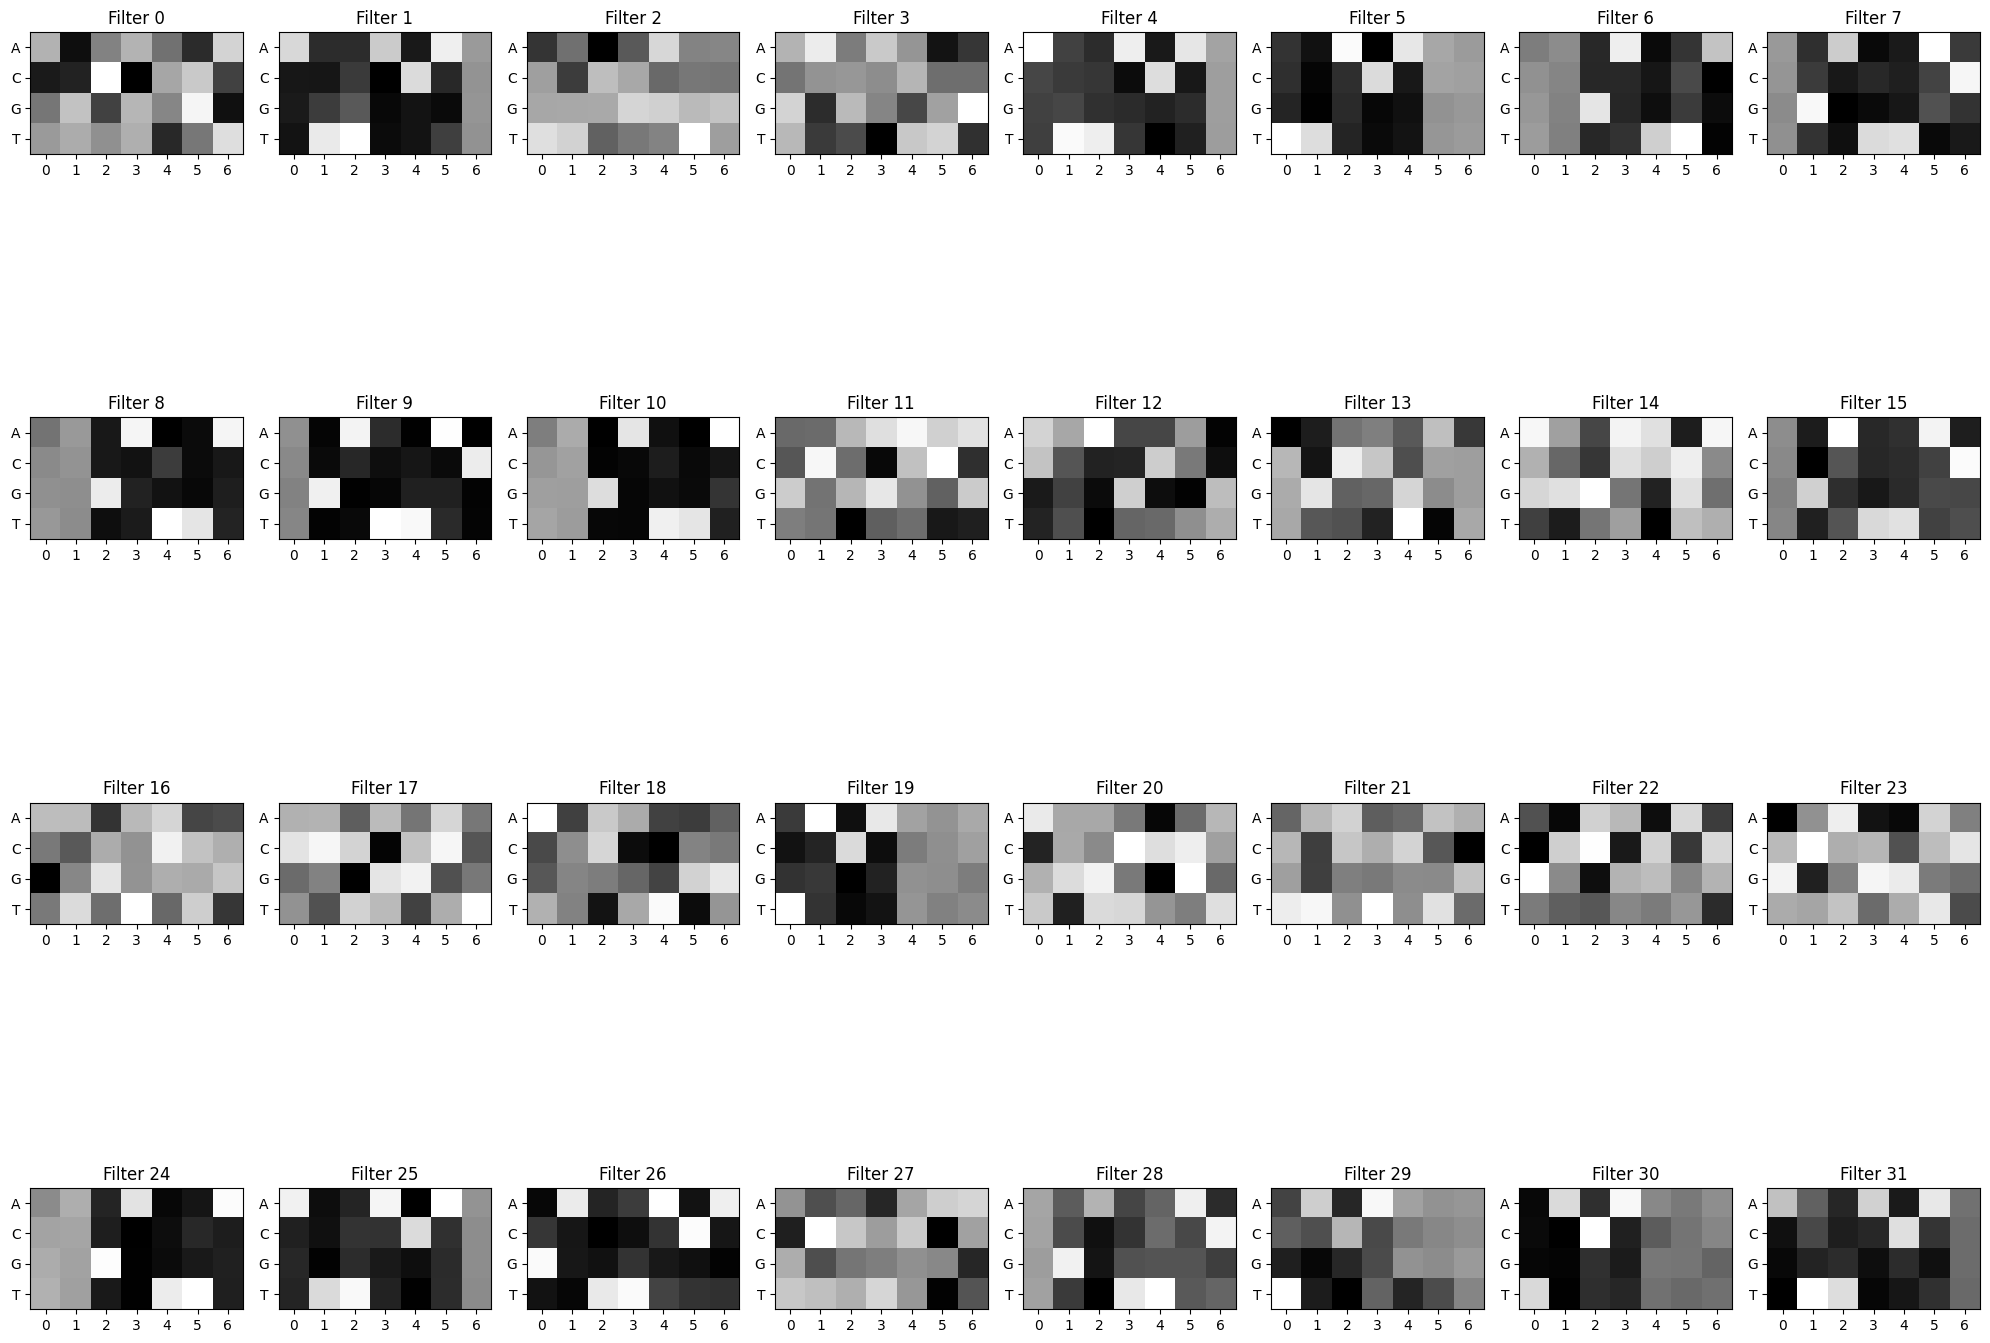

In [ ]:
print([f'{i}: {weights[i]}' for i in range(len(weights))])
conv_layers, model_weights, bias_weights = get_conv_layers_from_model(model_cnn)
view_filters(model_weights)

# Crap Code

In [ ]:
#optimization
import torch.optim as optim

steps = 10000
lossi = []
batch_size = 100
Xin = sXenc
Yin = sYtr
# lr = 0.001
loss = nn.MSELoss()
linear = LinearNet(7)
net = linear
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

for i in range(steps):

  #batch construct
  ix = torch.randint(0, Xin.shape[0], (batch_size,))
  Xb, Yb = Xin[ix], Yin[ix]

  #forward pass
  output = net(Xb)
  loss_v = loss(output, Yb)
  lossi.append(loss_v.item())

  #backward pass
  loss_v.backward()
  optimizer.step()
  optimizer.zero_grad()



  if i % 100 == 0: # print every once in a while
    print(f'{i:7d}/{steps:7d}: {loss_v.item():.4f}')


In [ ]:
Ytr.shape

In [ ]:
Xdev = enc(Xdev)
Xte = enc(Xte)

@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xenc, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  loss = net(x, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

In [ ]:
sXenc.shape

In [ ]:
shapes = []
testxi = torch.reshape(sXenc[10], (1, 4, -1))
net(testxi)
shapestr = ''
# for shape in shapes:
#   shapestr += f'{shapes}---> '
shapestr

In [ ]:
for x, y in sxTr_dl:
  for i in range(50):
    xi = x[i].view(1, x[i].shape[0], x[i].shape[1])
    print(f'{model_lin(xi)} --> {y[i]}')

In [ ]:
shapes

In [ ]:
for seqs, labs in sxTr_dl:
  # print(f'seqs: {seqs[0]}')
  x_again = torch.argmax(seqs, dim=1)
  # print(f'x_again: {x_again[0]}')
strings = []
for x in x_again:
  # print(f'x: {x}')
  x_str = ''
  for i in x:
    i = i.item()
    x_str += itob[i]
  strings.append(x_str)
  # print(f'x_str: {x_str}')
# print(f'strings: {strings}')
ys = []
for item in labs:
  item = item.item()
  ys.append(item)

testzips = zip(strings, ys)

print(all([tup[1] == 0 for tup in testzips if tup[0] != gat]))
print(all([tup[1] == 1 for tup in testzips if tup[0] == gat]))
print(list(testzips))